In [5]:
import requests
import sys, os
import numpy as np
import json
from time import sleep
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt

#### Functions to make API calls and return lines (no need to edit)

In [15]:
def get_data(url):
    '''Geocode from location string and return latitude longitude'''

    payload, headers = {}, {}
    response = requests.request("GET", url, headers=headers, data=payload)
    return json.loads(response.text)

def get_coord_list(r):
    '''Get ordered list of all intermediate locations'''
    
    all_coords = r['route']['shape']['shapePoints']
    lats = all_coords[::2]
    lngs = all_coords[1::2]
    return lats, lngs

def coords_to_line(lats, lngs):
    '''converst lat lng lists to a shapely line geometry'''
    
    coord_list = []
    for lat, lng in zip(lats, lngs):
        coord_list.append((lng, lat))
        
    return LineString(coord_list)


def get_dirs(loc_list, mq_key):
    '''get continous point list from list of waypoint locations'''
    
    all_lats, all_lngs = [], []    
    points, markers, labels = [], [], []
    
    for i in range(len(loc_list)-1):
        
        # each start is the previous destination
        start = loc_list[i]
        dest = loc_list[i+1]
        url = f'http://open.mapquestapi.com/directions/v2/route?key={mq_key}&from={start}&to={dest}&fullShape=True'
        r = get_data(url)
        
        # makes sure request did not return an error
        try: 
            lats, lngs = get_coord_list(r)
            print(start, dest, len(lats), len(lngs))
        except: 
            print(start, dest, r)
            
        # append new list to previous
        all_lats += lats
        all_lngs += lngs
        
    line = coords_to_line(all_lats, all_lngs)
    return line

#### Add your info below

In [23]:
# Make an account of mapquest API to obtain a key
# https://developer.mapquest.com/documentation/open/directions-api/route/get

# plug in your key here, or load in from a file (like I'm doing)
mq_key = open('mapquest_key.txt', 'r').readlines()[0]

# load in the background shp file for the map background
path_to_shp = 'cb_2018_us_state_5m.shp'

# make a list of searchable locations for each rodtrip
# the code will search for the fastest route between each successive location

locs_19 = ['Irvine, California',
           'Santa Barbara, California', 
           'Big Sur, CA', 
           'Sausalito, CA',
           'Mendocino, California',
           'Crescent City, California', 
           'Bend, OR',
           'Hood River, OR',
           'Portland, OR',
           'Astoria, Washington',
           'Forks, WA',
           'Seattle, WA']

locs_21 = ['Chicago, IL', 
           'Mariemont, OH',
           'Asheville, NC',
           'Charlotte, NC',
           'Charleston, SC',
           'Beaufort, SC',
           'Savannah, GA', 
           'Atlanta, GA',
           'LaFayette, GA',
           'Cloudland Canyon State Park', 
           'Chattanooga, TN',
           'Huntsville, AL',
           'Nashville, TN',
           'Paducah, KY',
           'Norris City, IL',
           'Champaign, IL', 
           'Chicago, IL']

locs_22 = ['Chicago, IL',
           'Cape Girardeau, MO', 
           'Memphis, TN', 
           'Jackson, MS',
           'Port Gibson, MS', 
           'Natchez, MS',
           'Roxie, MS',
           'New Orleans', 
           'Baton Rouge, LA',
           'Houston, TX', 
           'Austin, TX', 
           'San Antonio, TX', 
           'Austin, TX',
           'Dallas, TX',
           'Muskogee, OK',
           'Fayetteville, AR',
           'Harrison, AR',
           'Branson, MO', 
           'St. Louis, MO',
           'Chicago, IL']


#### Generate line for each trip -- this will take about 1 second per location. Mapquest is not as flexible at google maps API, so you may need to change or generalize the name slightly

In [40]:
# generate line for each trip -- this will take about 1 second per location
line_19 = get_dirs(locs_19, mq_key)
line_21 = get_dirs(locs_21, mq_key)
line_22 = get_dirs(locs_22, mq_key)

Irvine, California Santa Barbara, California 1651 1651
Santa Barbara, California Big Sur, CA 3703 3703
Big Sur, CA Sausalito, CA 2456 2456
Sausalito, CA Mendocino, California 2222 2222
Mendocino, California Crescent City, California 5898 5898
Crescent City, California Bend, OR 3375 3375
Bend, OR Hood River, OR 1810 1810
Hood River, OR Portland, OR 801 801
Portland, OR Astoria, Washington 1181 1181
Astoria, Washington Forks, WA 2819 2819
Forks, WA Seattle, WA 2062 2062
Chicago, IL Mariemont, OH 2870 2870
Mariemont, OH Asheville, NC 3862 3862
Asheville, NC Charlotte, NC 1407 1407
Charlotte, NC Charleston, SC 1399 1399
Charleston, SC Beaufort, SC 724 724
Beaufort, SC Savannah, GA 516 516
Savannah, GA Atlanta, GA 1361 1361
Atlanta, GA LaFayette, GA 1269 1269
LaFayette, GA Cloudland Canyon State Park 521 521
Cloudland Canyon State Park Chattanooga, TN 598 598
Chattanooga, TN Huntsville, AL 1191 1191
Huntsville, AL Nashville, TN 1071 1071
Nashville, TN Paducah, KY 1038 1038
Paducah, KY Norri

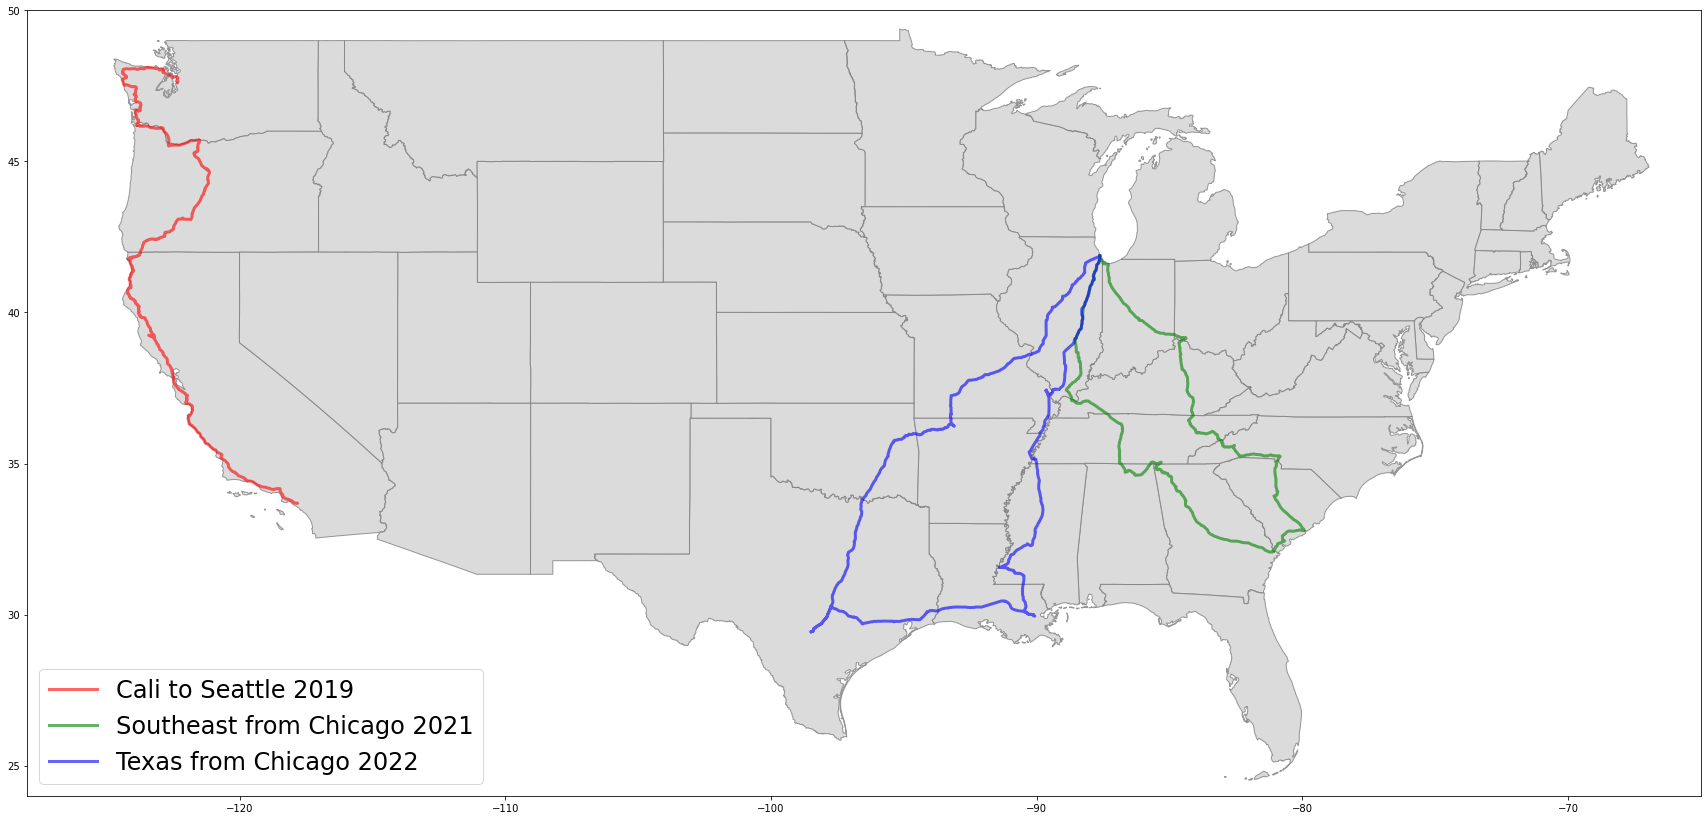

In [46]:
# plots lines on a shared axis

# chang width and ta
linewidth=3
alpha=0.6

gdf = gpd.read_file(path_to_shp)

# plot on background map
axis = gdf.plot(figsize=(30, 15), color='lightgray', edgecolor='gray', alpha=0.8)

# axis limits for map
axis.set_xlim(-128, -65)
axis.set_ylim(24, 50)

# plot lines
axis.plot(*line_19.xy, c='red', linewidth=linewidth, alpha=alpha, label='Cali to Seattle 2019')
axis.plot(*line_21.xy, c='green', linewidth=linewidth, alpha=alpha, label='Southeast from Chicago 2021')
axis.plot(*line_22.xy, c='blue', linewidth=linewidth, alpha=alpha, label='Texas from Chicago 2022')

axis.legend(fontsize=24, loc='lower left')

#### Work in progress: adding markers in labels such that they don't crowd each other out

Chicago, IL Mariemont, OH 2870 2870
Mariemont, OH Asheville, NC 3862 3862
Asheville, NC Charlotte, NC 1407 1407
Charlotte, NC Charleston, SC 1399 1399
Charleston, SC Beaufort, SC 724 724
Beaufort, SC Savannah, GA 516 516
Savannah, GA Atlanta, GA 1361 1361
Atlanta, GA LaFayette, GA 1269 1269
LaFayette, GA Cloudland Canyon State Park 521 521
Cloudland Canyon State Park Chattanooga, TN 598 598
Chattanooga, TN Huntsville, AL 1191 1191
Huntsville, AL Nashville, TN 1071 1071
Nashville, TN Paducah, KY 1038 1038
Paducah, KY Norris City, IL 887 887
Norris City, IL Champaign, IL 1379 1379


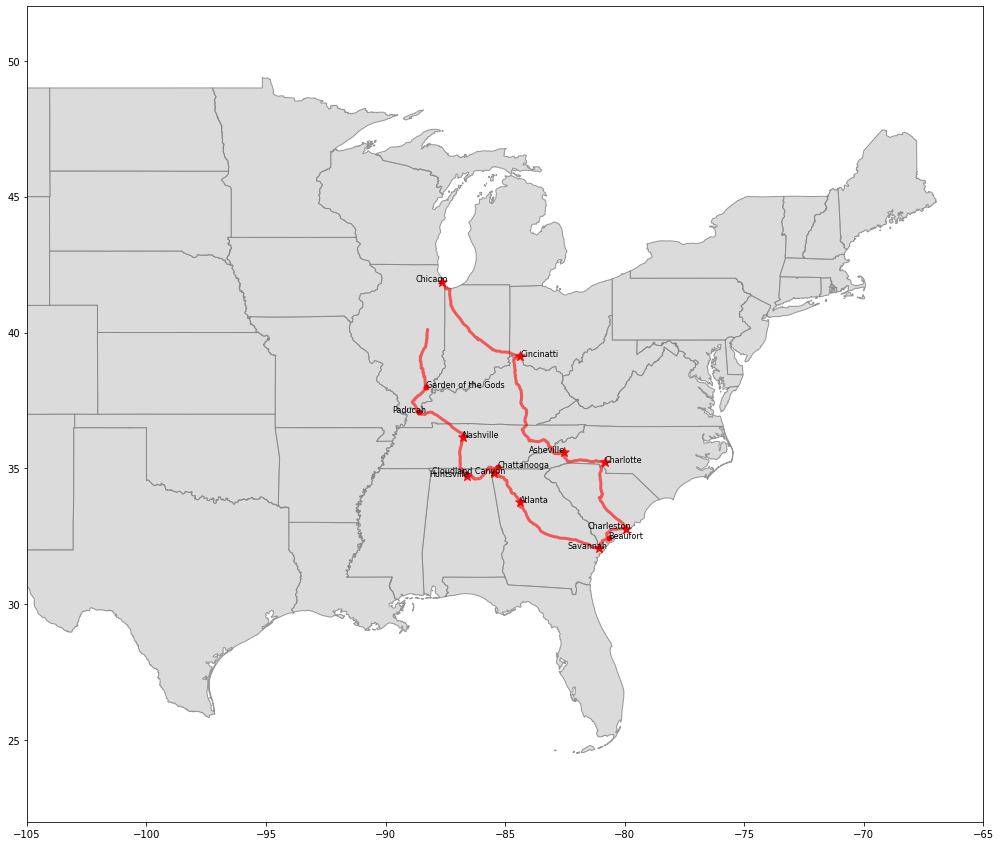

In [22]:

def get_dir_list(locs, mq_key='unhe7GeBIY8OUUYoJNRlACkCi2wHL9VS', mark_day='.', mark_night='*'):
    '''get continous point list from list of waypoint locations'''
    
    if type(locs) is dict:
        loc_list = [key for key in locs.keys()]
        name_list = [value[0] for value in locs.values()]
        stay_list = [value[1] for value in locs.values()]
    
    all_lats, all_lngs = [], []    
    points, markers, labels = [], [], []
    
    for i in range(len(loc_list)-1):
        
        # each start is the previous destination
        start = loc_list[i]
        dest = loc_list[i+1]
        url = f'http://open.mapquestapi.com/directions/v2/route?key={mq_key}&from={start}&to={dest}&fullShape=True'
        r = get_data(url)
        
        # makes sure request did not return an error
        try: 
            lats, lngs = get_coord_list(r)
            print(start, dest, len(lats), len(lngs))
        except: 
            print(start, dest, r)
            
        # append new list to previous
        all_lats += lats
        all_lngs += lngs
        
        if stay_list[i]=='night':
            markers.append(mark_night)
            labels.append(name_list[i])
            points.append([lngs[0], lats[0]])
            
        elif stay_list[i]=='day':
            markers.append(mark_day)
            labels.append(name_list[i])
            points.append([lngs[0], lats[0]])
        
    line = coords_to_line(all_lats, all_lngs)

    return line, (np.array(points), markers, labels)


locs_21 = {'Chicago, IL'  :    ['Chicago', 'night'],  #day, night, None
           'Mariemont, OH':    ['Cincinatti', 'night'],
           'Asheville, NC':    ['Asheville', 'night'],
           'Charlotte, NC':   ['Charlotte', 'night'],
           'Charleston, SC':  ['Charleston', 'night'],
           'Beaufort, SC':    ['Beaufort', 'day'],
           'Savannah, GA':    ['Savannah', 'night'],
           'Atlanta, GA':     ['Atlanta', 'night'],
           'LaFayette, GA':   ['', 'waypoint'],
           'Cloudland Canyon State Park': ['Cloudland Canyon', 'night'],
           'Chattanooga, TN': ['Chattanooga', 'day'],
           'Huntsville, AL':  ['Huntsville', 'night'],
           'Nashville, TN':   ['Nashville', 'night'],
           'Paducah, KY':     ['Paducah', 'day'],
           'Norris City, IL': ['Garden of the Gods', 'day'],
           'Champaign, IL':   ['Champaign', 'night'], 
           'Chicago, IL':     ['Chicago', 'night']
          }


line_21, scatter_21 = get_dir_list(locs_21)


# use chicago as reference and plot globally

def dir_plot(line, scatter, axis, s=100, fontsize=14, linewidth=3, alpha=0.6):
    '''Plot line along mapquest interpolation and scatter pints'''
    
    axis.plot(*line_21.xy, c='red', linewidth=linewidth, alpha=alpha)
    (points, markers, labels) = scatter
    for i, (p, m, l) in enumerate(zip(points, markers, labels)):
        
        x, y = p
        axis.scatter(x, y, marker=m, c='red', s=s)
        
        # ajdust every other annotation by length of name
        if i%2==0:
            x -= len(l)*0.16
        axis.annotate(l, (x, y), fontsize=fontsize)

# plot parameters
linewidth=3
alpha=0.6

path_to_shp = '../shape_files/cb_2018_us_state_5m/cb_2018_us_state_5m.shp' #gpd.datasets.get_path('naturalearth_lowres')
gdf = gpd.read_file(path_to_shp)

# plot on background map
axis = gdf.plot(figsize=(30, 15), color='lightgray', edgecolor='gray', alpha=0.8)
axis.set_xlim(-105, -65)
axis.set_ylim(22, 52)

# plot lines
#axis.plot(*line_19.xy, c='green', linewidth=linewidth, alpha=alpha)
#axis.plot(*line_22.xy, c='blue', linewidth=linewidth, alpha=alpha)
#axis.plot(*line_21.xy, c='red', linewidth=linewidth, alpha=alpha)

dir_plot(line_21, scatter_21, axis, fontsize=8)